In [1]:
import numpy as np
import random
from structures import *
import matplotlib.pyplot as plt

In [6]:
TIMESTEPS = 60    # 1 timestep = 5 min
N_STATIONS = 12
DOCKS_PER_STATION = 10
INIT_BIKES_PER_STATION = 8
RESERVATION_LIMIT = 5

RIDE_DENSITY_AVG = 10
RIDE_DENSITY_STD = 2
RIDE_LEN_AVG = 4
RIDE_LEN_STD = 3

WANT_EBIKE_PROB = 0.3

RESERVATION_DENSITY_AVG = 3
RESERVATION_DENSITY_STD = 1


def run_simulation():
    rides_log = [0]
    failed_checkout_log = [0]
    failed_dock_log = [0]
    failed_reservation_log = [0]
    
    stations = []
    current_rides = []
    
    # create stations
    for station in range(N_STATIONS):
        # currently no EBIKES
        stations.append(Station(DOCKS_PER_STATION,
                                int(INIT_BIKES_PER_STATION*(1-WANT_EBIKE_PROB)),
                                int(INIT_BIKES_PER_STATION*WANT_EBIKE_PROB),
                                RESERVATION_LIMIT))
    
    # run simulation!
    for time in range(TIMESTEPS):
        n_checkout_fails = 0
        n_dock_fails = 0
        n_reservation_fails = 0
        
        # start new rides
        n_rides_started = sample_norm_int(RIDE_DENSITY_AVG, RIDE_DENSITY_STD, 0)
        for _ in range(n_rides_started):
            # choose ride attributes
            start = random.choice(stations)
            destination = random.choice(stations)
            length = sample_norm_int(RIDE_LEN_AVG, RIDE_LEN_STD, 1)

            # choose bike type that user wants to check out
            desired_btype = "SBIKE" if random.random() > WANT_EBIKE_PROB else "EBIKE"

            # TODO: if ebike conversion possible, if checking out SBIKE fails we should try to check out an EBIKE
            if start.check_out(desired_btype):
                # checkout successful
                new_ride = Ride(start, destination, time, length)
                current_rides.append(new_ride)
            else:
                # no bikes available
                n_checkout_fails += 1

        # generate reservations for random stations before starting new rides
        n_reservations = sample_norm_int(RESERVATION_DENSITY_AVG, RESERVATION_DENSITY_STD, 0)
        for _ in range(n_reservations):
            station = random.choice(stations)
            bike_type = random.choice(["SBIKE", "EBIKE"])
            if not station.reserve_bike(bike_type):
                n_reservation_fails += 1
        
        # check for rides finishing
        updated_current_rides = []
        for ride in current_rides:
            if ride.start_time + ride.length <= time:   # check if they're done riding
                if ride.destination.return_bike("SBIKE"):  # try to return bike
                    # return successful
                    pass
                else:
                    # return failed
                    updated_current_rides.append(ride)
                    n_dock_fails += 1
            else:
                updated_current_rides.append(ride)
    
        rides_log.append(len(current_rides))
        failed_checkout_log.append(n_checkout_fails)
        failed_dock_log.append(n_dock_fails)
        failed_reservation_log.append(n_reservation_fails)

        current_rides = updated_current_rides

    return rides_log, failed_checkout_log, failed_dock_log, failed_reservation_log


rides, checkout_fails, dock_fails, reserve_fails = run_simulation()

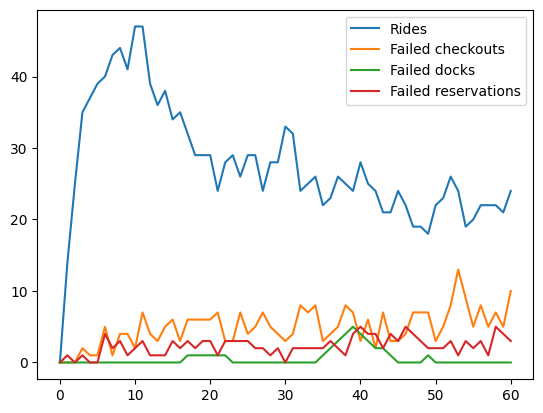

In [7]:
plt.plot(rides, label="Rides")
plt.plot(checkout_fails, label="Failed checkouts")
plt.plot(dock_fails, label="Failed docks")
plt.plot(reserve_fails, label="Failed reservations")
plt.legend()